In [141]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [223]:
NUM_EPOCHS = 20
BATCH_SIZE = 256
BUFFER_SIZE = 1024
STEPS_PER_EPOCH = 100
LEARNING_RATE = 0.01

ACTIVATION_ELU = tf.keras.activations.elu
ACTIVATION_SOFTPLUS = tf.keras.activations.softplus
ACTIVATION = ACTIVATION_ELU

In [174]:
tf.keras.utils.set_random_seed(42)

In [175]:
import tensorflow_probability as tfp
norm = tfp.distributions.Normal(loc=0., scale=1.)
norm.pdf = norm.prob

# helper analytics
def bsPrice(spot, strike, vol, T):
    d1 = (tf.math.log(spot/strike) + 0.5 * vol * vol * T) / vol / tf.math.sqrt(T)
    d2 = d1 - vol * tf.math.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (tf.math.log(spot/strike) + 0.5 * vol * vol * T) / vol / tf.math.sqrt(T)
    return norm.cdf(d1) 

def bsVega(spot, strike, vol, T):
    d1 = (tf.math.log(spot/strike) + 0.5 * vol * vol * T) / vol / tf.math.sqrt(T)
    return spot * tf.math.sqrt(T) * norm.pdf(d1)

class BlackScholes:
        
    def __init__(self, 
                vol=0.2,
                T1=1.0, 
                T2=2.0, 
                K=1.10,
                volMult=1.5):
            
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                            
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
        
        tf.random.set_seed(seed)
            
        # 2 sets of normal returns
        returns = tf.random.normal(shape=[m, 2])
    
        # SDE
        vol0 = self.vol * self.volMult
        R1 = tf.exp(-0.5*vol0*vol0*self.T1 + vol0*tf.math.sqrt(self.T1)*returns[:,0])
        R2 = tf.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*tf.math.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 
    
        # payoff
        pay = tf.math.maximum(0, S2 - self.K)
            
        # two antithetic paths
        if anti:
                
            R2a = tf.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*tf.math.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = tf.math.maximum(0, S2a - self.K)
                
            X = S1
            Y = 0.5 * (pay + paya)
        
            # differentials
            Z1 =  tf.where(S2 > self.K, R2, 0.0)

            Z2 =  tf.where(S2a > self.K, R2a, 0.0) 
            Z = 0.5 * (Z1 + Z2)
                        
        # standard
        else:
            
            X = S1
            Y = pay

            # differentials
            Z =  tf.where(S2 > self.K, R2, 0.0)

        X = tf.reshape(X, [-1, 1])
        Y = tf.reshape(Y, [-1, 1])
        Z = tf.reshape(Z, [-1, 1])

        return X, Y, Z
        
    # test set: returns a grid of uniform spots
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=None):
                
        spots = tf.linspace(lower, upper, num)
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1)
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1)
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1)

        spots = tf.reshape(spots, [-1, 1])
        prices = tf.reshape(prices, [-1, 1])
        deltas = tf.reshape(deltas, [-1, 1])
        vegas = tf.reshape(vegas, [-1, 1])

        return spots, spots, prices, deltas, vegas

In [121]:
bs = BlackScholes()
x_train, y_train, dydx_train = bs.trainingSet(8192)
x_test, x_axis, y_test, dydx_test, vegas = bs.testSet(num=1000)

# reshape x_train to 2D
# x_train = tf.reshape(x_train, [-1, 1])

In [176]:
def plot_training_data(x_train, y_train, dydx_train, x_test, y_test, x_axis, dydx_test):
    plt.title("Training Data")
    # the same as plt.scatter(x_train, y_train) but with a thinner line is:
    plt.plot(x_train, y_train, 'r.', markersize=1)
    # now the other two with a thinner line:
    plt.plot(x_test, y_test, 'b.', markersize=1)
    plt.plot(x_train, dydx_train, 'g.', markersize=1)
    # plt.plot(x_axis, dydx_test, 'g.', markersize=1)
    # corresponding legend:
    plt.legend(['Training Data', 'True Price', 'Training Delta'], loc='upper left')
    plt.show()

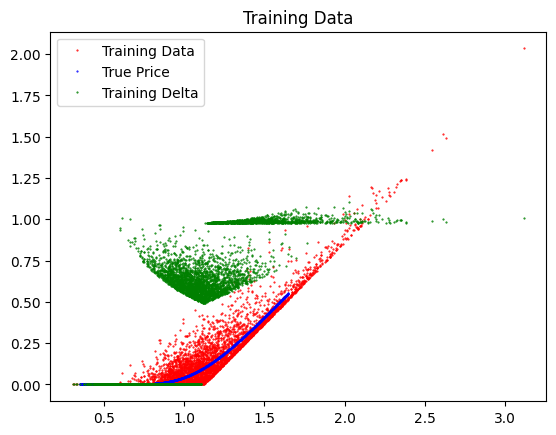

In [177]:
plot_training_data(x_train, y_train, dydx_train, x_test, y_test, x_axis, dydx_test)

In [178]:
print(x_train.shape, y_train.shape, dydx_train.shape)
print(x_test.shape, y_test.shape, x_axis.shape, dydx_test.shape, vegas.shape)

(8192, 1) (8192, 1) (8192, 1)
(1000, 1) (1000, 1) (1000, 1) (1000, 1) (1000, 1)


In [179]:
# prepare normalization layer for model
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(x_train)

x_train_norm = normalizer(x_train)
x_test_norm = normalizer(x_test)

In [180]:
model = tf.keras.Sequential([
    # normalizer,
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(1)
], name="SurrogateModel")

model.compile(optimizer='adam', loss='mse')

In [187]:
history = model.fit(x_train_norm, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(x_test_norm, y_test))

Epoch 1/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 1.5973e-05
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 1.6875e-05
Epoch 3/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 7.9710e-05
Epoch 4/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 4.3723e-05
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 7.4836e-05
Epoch 6/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 1.1869e-04
Epoch 7/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 2.3459e-05
Epoch 8/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 3.0782e-05
Epoch 9/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 1.2977e-05
Epoch 10/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0030 - 

In [188]:
print("Evaluate on test data")
results = model.evaluate(x_test_norm, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)


Evaluate on test data
4/4 [==============================] - 0s 2ms/step - loss: 3.3932e-05
test loss, test acc: 3.393158476683311e-05


32/32 [==============================] - 0s 1ms/step


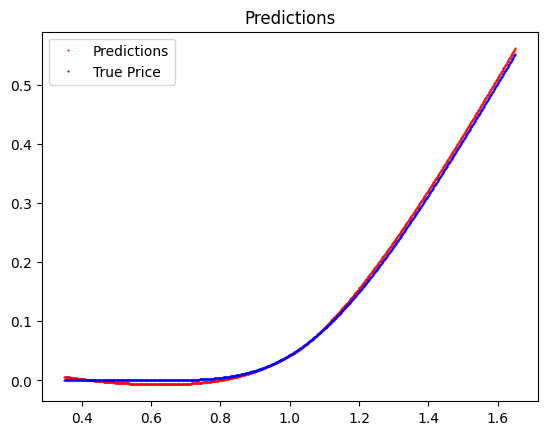

In [189]:

pred_y = model.predict(x_test_norm)
plt.title("Predictions")
plt.plot(x_test, pred_y, 'r.', markersize=1)
plt.plot(x_test, y_test, 'b.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()


In [232]:

# transform into tf.data.Dataset:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train, dydx_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test, dydx_test))

# shuffle and batch the datasets:
train_dataset = train_dataset.shuffle(BUFFER_SIZE, seed=42).batch(BATCH_SIZE)#.take(STEPS_PER_EPOCH)
test_dataset = test_dataset.batch(BATCH_SIZE) # .take(STEPS_PER_EPOCH)


Finished epoch   0  |  Loss: 0.05561
Finished epoch   1  |  Loss: 0.02824
Finished epoch   2  |  Loss: 0.02521
Finished epoch   3  |  Loss: 0.02235
Finished epoch   4  |  Loss: 0.01903
Finished epoch   5  |  Loss: 0.01548
Finished epoch   6  |  Loss: 0.01214
Finished epoch   7  |  Loss: 0.00957
Finished epoch   8  |  Loss: 0.00812
Finished epoch   9  |  Loss: 0.00755
Finished epoch  10  |  Loss: 0.00737
Finished epoch  11  |  Loss: 0.00729
Finished epoch  12  |  Loss: 0.00725
Finished epoch  13  |  Loss: 0.00719
Finished epoch  14  |  Loss: 0.00713
Finished epoch  15  |  Loss: 0.00707
Finished epoch  16  |  Loss: 0.00707
Finished epoch  17  |  Loss: 0.00693
Finished epoch  18  |  Loss: 0.00690
Finished epoch  19  |  Loss: 0.00700
32/32 [==============================] - 0s 1ms/step


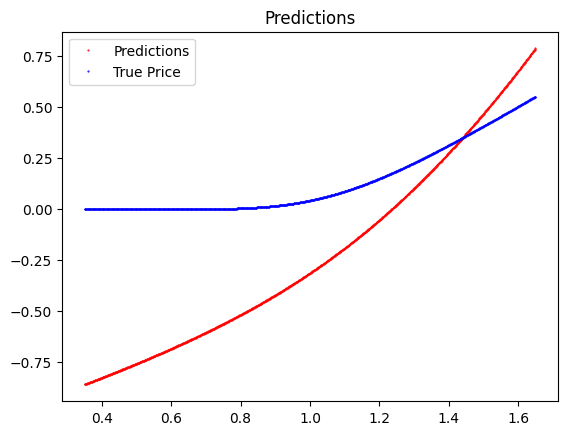

In [236]:
# create a new model
model = tf.keras.Sequential([
    # normalizer,
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(1)
], name="SurrogateModelWithDifferentials")

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_metric = tf.keras.metrics.Mean(name='train_loss')
loss_fn = tf.keras.losses.MeanSquaredError()

# define the loss function
def loss(model, x, y, dydx):
    y_ = model(x)
    # print(tf.keras.losses.mse(y_, y))
    # return tf.math.reduce_mean(tf.math.square(y_ - y)) #+ tf.math.reduce_mean(tf.math.square(dydx - tf.gradients(y_, x))) 
    return loss_fn(y_, y) #+ tf.keras.losses.MeanSquaredError()(dydx, tf.gradients(y_, x)
    # return tf.keras.losses.mse(tf.squeeze(y_), tf.squeeze(y))

model.compile(optimizer=optimizer, loss=loss)

# define the training step
@tf.function
def train_step(model, x, y, dydx):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y, dydx)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    loss_metric.update_state(loss_value)

for epoch in range(NUM_EPOCHS):

    loss_metric.reset_states()

    for xs, ys, dydxs in train_dataset:
        train_step(model, xs, ys, dydxs)

    mean_loss = loss_metric.result()
    
    print('Finished epoch {:3d}'.format(epoch), ' |  Loss: {:.5f}'.format(mean_loss))

# print("Evaluate on test data")
# results = model.evaluate(x_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

pred_y = model.predict(x_test_norm)
plt.title("Predictions")
plt.plot(x_test, pred_y, 'r.', markersize=1)
plt.plot(x_test, y_test, 'b.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()

In [234]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(1)
], name="SurrogateModelWithDifferentials")

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

y_loss_metric = tf.keras.metrics.Mean(name='y_loss')
total_loss_metric = tf.keras.metrics.Mean(name='total_loss')

loss_fn = tf.keras.losses.MeanSquaredError()

def loss(y_pred, y_true, dydx_pred, dydx_true):
    y_loss = loss_fn(y_true, y_pred)
    dy_loss = loss_fn(dydx_true, dydx_pred)

    alpha = 0.5
    beta = 1 - alpha
    return y_loss, alpha * y_loss + beta * dy_loss

model.compile(optimizer=optimizer, loss=loss)

# transform into tf.data.Dataset:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

# shuffle and batch the datasets:
train_dataset = train_dataset.shuffle(BUFFER_SIZE, seed=42).batch(BATCH_SIZE).take(STEPS_PER_EPOCH)
test_dataset = test_dataset.batch(BATCH_SIZE).take(STEPS_PER_EPOCH)

@tf.function
def train_step(model, x, y, dydx):
    with tf.GradientTape() as t1, tf.GradientTape() as t2:
        t1.watch(x)
        t2.watch(x)
        y_pred = model(x)

        #with t1.stop_recording():
        dydx_pred = t2.batch_jacobian(y_pred, x)
        dydx_pred = tf.squeeze(dydx_pred, axis=2)   

        y_loss, total_loss = loss(y_pred, y, dydx_pred, dydx)

    grads = t1.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    y_loss_metric.update_state(y_loss)
    total_loss_metric.update_state(total_loss)


for epoch in range(NUM_EPOCHS):
    y_loss_metric.reset_states()
    total_loss_metric.reset_states()
    for xs, ys, dydxs in train_dataset:
        train_step(model, xs, ys, dydxs)
        
    mean_loss = y_loss_metric.result()
    mean_total_loss = total_loss_metric.result()
    print('Finished epoch {:3d}'.format(epoch), 
          ' | y-loss: {:.5f}'.format(mean_loss),  
          ' | total-loss: {:.5f}'.format(mean_total_loss))



Finished epoch   0  | y-loss: 1.18871  | total-loss: 0.74490
Finished epoch   1  | y-loss: 0.04693  | total-loss: 0.16788
Finished epoch   2  | y-loss: 0.03155  | total-loss: 0.15107
Finished epoch   3  | y-loss: 0.02849  | total-loss: 0.14000
Finished epoch   4  | y-loss: 0.02561  | total-loss: 0.12880
Finished epoch   5  | y-loss: 0.02269  | total-loss: 0.11757
Finished epoch   6  | y-loss: 0.01968  | total-loss: 0.10680
Finished epoch   7  | y-loss: 0.01674  | total-loss: 0.09738
Finished epoch   8  | y-loss: 0.01422  | total-loss: 0.09029
Finished epoch   9  | y-loss: 0.01228  | total-loss: 0.08578
Finished epoch  10  | y-loss: 0.01102  | total-loss: 0.08327
Finished epoch  11  | y-loss: 0.01027  | total-loss: 0.08181
Finished epoch  12  | y-loss: 0.00981  | total-loss: 0.08068
Finished epoch  13  | y-loss: 0.00953  | total-loss: 0.07967
Finished epoch  14  | y-loss: 0.00928  | total-loss: 0.07866
Finished epoch  15  | y-loss: 0.00907  | total-loss: 0.07767
Finished epoch  16  | y-

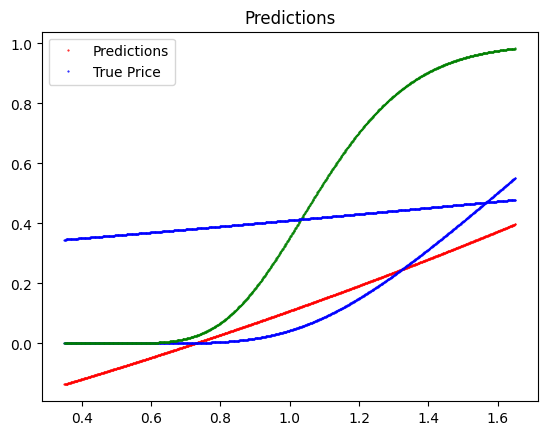

In [235]:
@tf.function
def eval(model, x, y, dydx):
    with tf.GradientTape() as t:
        t.watch(x)
        y_pred = model(x)
    
    dydx_pred = t.batch_jacobian(y_pred, x)
    dydx_pred = tf.squeeze(dydx_pred, axis=2)

    # dydx_pred = tf.gradients(y_pred, x)
    # dydx_pred = tf.squeeze(dydx_pred, axis=0)

    y_loss, total_loss = loss(y_pred, y, dydx_pred, dydx)
    
    return y_pred, dydx_pred


pred_y, pred_dydx = eval(model, x_test, y_test, dydx_test)
# print('y-loss: {:.5f}'.format(y_loss), 
        # ' | total-loss: {:.5f}'.format(total_loss))

# with tf.GradientTape() as t:
    # t.watch(x_test)
# pred_y = model.predict(x_test)

# pred_dydx = t.jacobian(pred_y, x_test)

plt.title("Predictions")
plt.plot(x_test, pred_y, 'r.', markersize=1)
plt.plot(x_test, y_test, 'b.', markersize=1)

plt.plot(x_test, dydx_test, 'g.', markersize=1)
plt.plot(x_test, pred_dydx, 'b.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()